In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn

### $N$-dimensional features, scalar regression target

### Setup

Define model as follows:
\begin{equation}
    y = a f_{\theta}(x) + b \qquad t = y + \sigma \epsilon \qquad \epsilon \sim \mathcal{N}(0, 1)
\end{equation}
with $a,b$ parameters with uniform Gaussian priors, $f_{\theta}$ a deterministic function, $t$ observations subject to random noise.

We might be interested in:
 - Predictive distribution $p_{\theta} (t\ |\ x) = \int_{a,b} \mathcal{N}(t\ |\ a f_{\theta}(x) + b, \sigma^2) \mathcal{N}(a\ |\ 0,1) \mathcal{N}(b\ |\ 0,1) \ da\ db$
 - Posterior inference $p_{\theta} (a, b\ |\ t, x) = \dfrac{p_{\theta} (t\ |\ a, b, x) p(a, b)}{p_{\theta} (t\ |\ x)}$, where denominator is intractable but necessary because it's a function of $\theta$.
 - ML (or MAP) estimate of $\theta$ to maximize $p_{\theta}(t | x)$
 
Approximate prior $p(a,b)$ with mean field variational distribution $q(a,b) = q(a)q(b)$. Then we can bound the predictive distribution given $\theta$ (marginal likelihood) as follows:
\begin{equation}
    p_{\theta} (t\ |\ x) \geq \mathcal{L} = \mathbb{E}_q[\log p_{\theta}(t\ |\ a, b, x)] - \mathrm{KL}(q(a,b) \ ||\ p(a,b))
\end{equation}
with
\begin{split}
\mathbb{E}_q[\log p_{\theta}(t\ |\ a, b, x)] = -\frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} \mathbb{E}_q[(t - a f_{\theta}(x) - b)^2] + \mathrm{const.}\\
\mathrm{KL}(q(a,b) \ ||\ p(a,b)) = -\frac{1}{2} \sum_{i\in\{a,b\}} \left(1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2\right)
\end{split}
We can compute analytically all terms except for the expected value which is MSE and we estimate by sampling as usual.

#### Toy Dataset 1

f shape: (200, 3)
a shape: (3, 1)


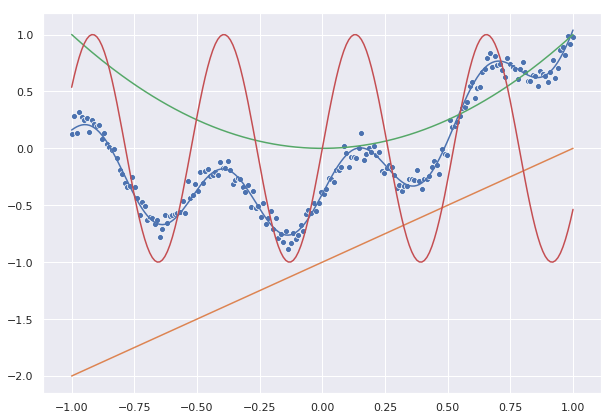

In [2]:
N = 200
a = np.array([0.6, 1, .3]).reshape(-1, 1)
b = 0.2
sigma = 0.06  # observation noise
x = np.linspace(-1, 1, N).reshape(-1, 1)
fx1 = x - 1
fx2 = x**2
fx3 = np.sin(12 * x)
fx = np.concatenate((fx1, fx2, fx3), axis=-1)
print('f shape:', fx.shape)
print('a shape:', a.shape)
t = fx @ a + b + sigma*np.random.randn(*x.shape)  # observations
plt.figure(figsize=(10, 7))
plt.plot(x, fx @ a + b)
plt.plot(x, fx)
sns.scatterplot(x[:, 0], t[:, 0])
plt.show() 

x = torch.tensor(x, dtype=torch.float)
t = torch.tensor(t, dtype=torch.float)

#### Features extractor and stochastic layer

Define function $f_{\theta}$ to extract features $h = f_{\theta}(x)$, with parameters $\theta$ to be optimized.

The stochastic layer has no state, it's only used to get samples from $\mathcal{N}(\mu, \sigma^2)$, and to compute the KL divergence from a prior $\mathcal{N}(0, 1)$ to a variational distribution $q = \mathcal{N}(\mu, \sigma^2)$.

In [3]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, n_out))
        
    def forward(self, x):
        return self.layers(x)
    
    
class StochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, logvar_q):
        """KL from standard normal. Independent variables, shape is irrelevant, KL is summed over all dimensions."""
        kl = -0.5 * (1 + logvar_q - mu_q.pow(2) - logvar_q.exp())
        return kl.sum()


### Optimize

Here we maximize the ELBO $\mathcal{L}$ with respect to variational parameters $\mu_a, \sigma_a, \mu_b, \sigma_b$, the NN parameters $\theta$, and the noise std $\sigma$.

In [4]:
features = FeaturesExtractor(n_out=a.shape[0])
stochastic = StochasticLayer()
l_rate = 0.01
epochs = 5000
n_samples = 10  # MC samples per example
mu_a = nn.Parameter(torch.zeros(*a.shape))
logvar_a = nn.Parameter(torch.zeros(*a.shape))
mu_b = nn.Parameter(torch.tensor([[0.]]))
logvar_b = nn.Parameter(torch.tensor([[0.]]))
logvar = nn.Parameter(torch.tensor(0.))  # for noise
optimiser = torch.optim.Adam(list(features.parameters()) + [mu_a, logvar_a, mu_b, logvar_b, logvar], lr = l_rate)

for epoch in range(epochs):
    optimiser.zero_grad()
    h = features(x)
    expected_mse = 0.
    expected_kl_term = 0.
    for i in range(n_samples):
        ## Sample once from q(a) q(b)
        a = stochastic(mu_a, logvar_a)
        b = stochastic(mu_b, logvar_b)
        y = h @ a + b  # stochasticity here only comes from a and b
        expected_mse += (t - h @ a - b)**2
        
        ## KL = E[log q(a, b) - log p(a, b)]
        ## log q(a) = -1/2 log(pi) - 1/2 logvar_a - 1/2 (a - mu_a)**2 / var_a
        ## KL sample: -1/2 (logvar_a + logvar_b) -1/2 (a-mu_a)**2/var_a -1/2 (b-mu_b)**2/var_b +1/2 a**2 +1/2 b**2
        ## Just sample -(a-mu_a)**2/var_a - (b-mu_b)**2/var_b + a**2 + b**2
        ## then multiply by 1/2 and add -1/2 logvar_ab.sum()
        expected_kl_term += (a**2).sum() + b**2 - ((a - mu_a)**2/logvar_a.exp()).sum() - (b - mu_b)**2/logvar_b.exp()
    expected_mse /= n_samples
    expected_kl_term /= n_samples
    
    ## Reconstruction loss, estimated by MC
    recons = (0.5/logvar.exp() * expected_mse + 0.5*logvar).flatten()  # recons per example
    recons = recons * N   # recons loss for whole data set

    ## KL loss, both analytic and by MC
    kl_estimate = (0.5*expected_kl_term - 0.5*logvar_a.sum() - 0.5*logvar_b.sum()).item()
    kl = stochastic.get_kl(mu_a, logvar_a) + stochastic.get_kl(mu_b, logvar_b)

    loss = recons + kl_estimate
    loss = loss.mean()
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0 or epoch == epochs-1:
        print('epoch {}, loss {:.4g}, recons {:.4g}, KL {:.4g} (analytical: {:.4g})'.format(epoch, loss, recons.mean(), kl_estimate, kl))

epoch 0, loss 220.6, recons 220.6, KL -5.151e-09 (analytical: 0)
epoch 250, loss -16.5, recons -19.52, KL 3.026 (analytical: 2.932)
epoch 500, loss -185.3, recons -191, KL 5.71 (analytical: 6.059)
epoch 750, loss -236.1, recons -243.6, KL 7.535 (analytical: 7.791)
epoch 1000, loss -233.4, recons -242, KL 8.562 (analytical: 9.135)
epoch 1250, loss -249.1, recons -258.9, KL 9.796 (analytical: 10.06)
epoch 1500, loss -265.8, recons -277.9, KL 12.11 (analytical: 11.71)
epoch 1750, loss -268.2, recons -282.5, KL 14.3 (analytical: 13.93)
epoch 2000, loss -289.3, recons -304.9, KL 15.61 (analytical: 15.84)
epoch 2250, loss -278.2, recons -295.1, KL 16.88 (analytical: 16.67)
epoch 2500, loss -284.5, recons -301.9, KL 17.34 (analytical: 17.47)
epoch 2750, loss -298.8, recons -317, KL 18.27 (analytical: 17.9)
epoch 3000, loss -402.1, recons -421, KL 18.9 (analytical: 19.49)
epoch 3250, loss -410.5, recons -430.6, KL 20.03 (analytical: 20.33)
epoch 3500, loss -411.8, recons -432.2, KL 20.45 (anal

### Visualization

First we sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

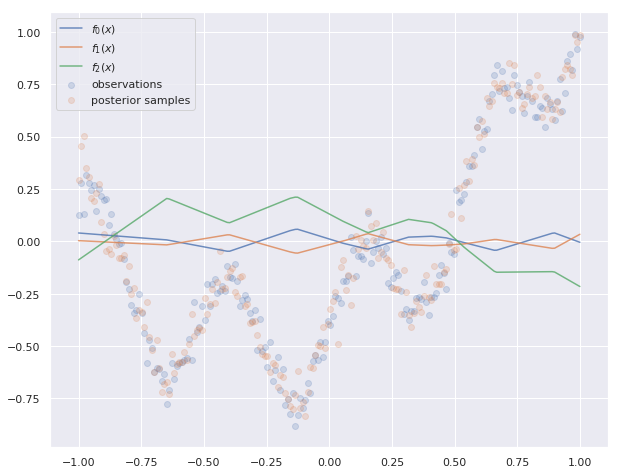

In [5]:
# Get parameters of q(a) and q(b)
mu_a_ = mu_a.detach().numpy()
mu_b_ = mu_b.detach().numpy()
std_a = (logvar_a/2).exp().detach().numpy()
std_b = (logvar_b/2).exp().detach().numpy()

# Sample a, b ~ q(a, b)
n_samples = t.shape[0]
a = np.random.multivariate_normal(mu_a_.flatten(), np.diag(std_a.flatten()**2), n_samples)
a = np.expand_dims(a, -1)
b = np.random.randn(n_samples) * std_b + mu_b_

# plt.figure(figsize=(6, 6))
# plt.pcolor
# plt.scatter(a, b, s=5)
# plt.xlabel('a')
# plt.ylabel('b')
# plt.title('samples from q(a, b)')
# plt.gca().set_aspect('equal', 'datalim')  # equal aspect ratio
# plt.show()

# For each x_i, use samples a_i, b_i to compute predicted t_i
h_ = features(x).detach().numpy()
# Do weird shape stuff because now we have many samples of a and b (unlike during training)
post_samples = (np.expand_dims(h_, 1) @ a).flatten() + b.flatten() + (logvar/2).exp().detach().numpy() * np.random.randn(n_samples)
plt.figure(figsize=(10,8))
plt.scatter(x, t, alpha=0.2, label='observations')
plt.scatter(x, post_samples, alpha=0.2, label='posterior samples')
for i in range(h.shape[1]):
    plt.plot(x.numpy(), h_[:, i], alpha=0.8, label='$f_{}(x)$'.format(i))
# plt.plot(x.numpy(), p5.numpy(), '--', color=sns.color_palette()[1], label='95% posterior interval')
# plt.plot(x.numpy(), p95.numpy(), '--',color=sns.color_palette()[1])
plt.legend()
plt.show()

In [6]:
print('a: N({}, {})'.format(mu_a_.flatten(), logvar_a.exp().detach().numpy().flatten()))
print('b: N({:.3g}, {:.3g})'.format(mu_b_[0,0], logvar_b.exp().detach().numpy()[0,0]))
print('noise var: {:.3g} (true value {:.3g})'.format(logvar.exp(), sigma**2))

a: N([-1.5617214  0.6550201 -3.8741834], [9.3280181e-04 1.8911399e-03 4.9869155e-05])
b: N(0.136, 1.48e-05)
noise var: 0.00429 (true value 0.0036)
